In [1]:
# Import Required Libariries
import pandas as pd
from collections import Counter

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import re
from nltk.stem import PorterStemmer
import spacy
from spacy.tokenizer import Tokenizer

In [2]:
# NLP utilities

class HandleTokens(object):
    @staticmethod
    def tokenize(df_in):
        tokens = []
        for doc in tokenizer.pipe(df_in, batch_size=500):
            doc_tokens = [token.text for token in doc]
            tokens.append(doc_tokens)
        return tokens
    @staticmethod
    def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
    @staticmethod
    def stopwords(list_in):
        return nlp.Defaults.stop_words.union(list_in)
    
    @staticmethod
    def combine_stopwords(dataframe_in, stopword_dict):
        tokens = []

        for doc in tokenizer.pipe(dataframe_in, batch_size=500):

            doc_tokens = []

            for token in doc: 
                if token.text.lower() not in stopword_dict:
                    doc_tokens.append(token.text.lower())

            tokens.append(doc_tokens)

        return tokens

## Data cleaning
The scraped questions and answer data comes with html tags that needs to be removed and cleaned, we should use the BeautifulSoup library to clean the data into a more usable format. 

In [3]:
df = pd.read_json('data.json')
df

,scraped_question,scraped_answer
0,[<strong>Q1. What organs are excised is an ova...,"[<div class=""su-spoiler-content su-u-clearfix ..."


In [4]:
questions = df['scraped_question'][0]
questions

['<strong>Q1. What organs are excised is an ovarian tumor is malignant?</strong>',
 '<strong>Q2.\xa0The spiral conical structure of the inner ear is the?,</strong>',
 '<strong>Q3. What is the term for a relationship in which two organisms occupy the same area and one organism benefits while the other is unharmed?</strong>',
 '<strong>Q4.\xa0Permission for treatment given with full knowledge of the risks is a/an?</strong>',
 '<strong>Q5.\xa0Which of the following is a method of high-level disinfection?</strong>',
 '<strong>Q6.\xa0The mumps may be diagnosed by finding inflammation in which of the following glands?</strong>',
 '<strong>Q7. How should the stretcher be oriented when necessary to use an elevator to transport a patient to the or?</strong>',
 '<strong>Q8. Which of the following solutions should be used to prep the donor site for a split-thickness skin graft?</strong>',
 '<strong>Q9. What type of procedure would involve the removal of teeth?</strong>',
 '<strong>Q10.\xa0Which o

In [5]:
answers = df['scraped_answer'][0][1:]
answers

['<p>If a tumor of an ovary is found to be malignant, the surgeon will excise the other ovary, both fallopian tubes, and the uterus to ensure that all cancer cells have been removed.<br>\n</p>',
 '<div class="su-spoiler-content su-u-clearfix su-u-trim">\xa0<strong><span style="color: #008000;">Correct option: 2<br>\n</span></strong>Sol: The cochlea is a bony spiral canal in the ear.\n</div>',
 '<div class="su-spoiler-content su-u-clearfix su-u-trim">\xa0<strong><span style="color: #008000;">Correct option: 4<br>\n</span></strong>Sol: A myomectomy is a procedure performed for the removal of fibromyomas or fibroid tumors from the uterine wall.\n</div>',
 '<div class="su-spoiler-content su-u-clearfix su-u-trim">\xa0<strong><span style="color: #008000;">Correct option: 1<br>\n</span></strong>Sol: The patient should be placed in the elevator entering headfirst and exit feet first when being transported to the O.R. on the stretcher.\n</div>',
 '<div class="su-spoiler-content su-u-clearfix su

In [6]:
nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

In [8]:
from bs4 import BeautifulSoup

def prettify_list(list_in, slice_in):
    questions = list_in
    state = []
    for i,x in enumerate(questions):
        # Replace scraped metatags and encoding
        a = questions[i].replace(u'\xa0', u'')
        a = a.replace(u'Correct', u'')
        a = a.replace(u'option:', u'')
        
        a = a.replace(u'\n', u'')
        
        
        soup = BeautifulSoup(a, 'html.parser')
        state.append(soup.get_text()[slice_in:])

    return state

Q_list = prettify_list(questions, 0)
Q_list

['Q1. What organs are excised is an ovarian tumor is malignant?',
 'Q2.The spiral conical structure of the inner ear is the?,',
 'Q3. What is the term for a relationship in which two organisms occupy the same area and one organism benefits while the other is unharmed?',
 'Q4.Permission for treatment given with full knowledge of the risks is a/an?',
 'Q5.Which of the following is a method of high-level disinfection?',
 'Q6.The mumps may be diagnosed by finding inflammation in which of the following glands?',
 'Q7. How should the stretcher be oriented when necessary to use an elevator to transport a patient to the or?',
 'Q8. Which of the following solutions should be used to prep the donor site for a split-thickness skin graft?',
 'Q9. What type of procedure would involve the removal of teeth?',
 'Q10.Which of the following is a fenestrated drape?',
 'Q11. Compression of the heart from excessive fluid or blood buildup is called?',
 'Q12.Which is the first part of the small intestine?',


In [9]:
# Reformat first item of answer list for fidelity
a1 = prettify_list(answers, 0)[0]
ans_list = prettify_list(answers, 8)
ans_list.pop(0)
ans_list.insert(0, a1)
ans_list

['If a tumor of an ovary is found to be malignant, the surgeon will excise the other ovary, both fallopian tubes, and the uterus to ensure that all cancer cells have been removed.',
 'The cochlea is a bony spiral canal in the ear.',
 'A myomectomy is a procedure performed for the removal of fibromyomas or fibroid tumors from the uterine wall.',
 'The patient should be placed in the elevator entering headfirst and exit feet first when being transported to the O.R. on the stretcher.',
 '2% glutaraldehyde is a type of high-level disinfectant solution; the device must be complete submerse for 20 minutes at room temperature in order to be disinfected',
 'The parotid glands are located inferior and anterior to the ears between the skin and masseter muscle. The parotid glands are attacked by the mumps virus.',
 'The patient should be placed in the elevator entering headfirst and exit feet first when being transported to the O.R. on the stretcher.',
 'The donor site should be scrubbed with a c

In [10]:
# Compile these lists into a dictionary to export, and to be used consumed in fontend applications. 

dict_out = {'Questions': Q_list, 'Answers': ans_list}
dict_out

{'Questions': ['Q1. What organs are excised is an ovarian tumor is malignant?',
  'Q2.The spiral conical structure of the inner ear is the?,',
  'Q3. What is the term for a relationship in which two organisms occupy the same area and one organism benefits while the other is unharmed?',
  'Q4.Permission for treatment given with full knowledge of the risks is a/an?',
  'Q5.Which of the following is a method of high-level disinfection?',
  'Q6.The mumps may be diagnosed by finding inflammation in which of the following glands?',
  'Q7. How should the stretcher be oriented when necessary to use an elevator to transport a patient to the or?',
  'Q8. Which of the following solutions should be used to prep the donor site for a split-thickness skin graft?',
  'Q9. What type of procedure would involve the removal of teeth?',
  'Q10.Which of the following is a fenestrated drape?',
  'Q11. Compression of the heart from excessive fluid or blood buildup is called?',
  'Q12.Which is the first part o

## Topic Modeling 
Create a LDA topic model of the review text then visualize the most common topics in the CST exam.

In [20]:
#save lem state
class LemState(object):
    def __init__(self):
        self._lem = "state"
        
    @property
    def lem(self):
        return self._lem
    
    @lem.setter
    def lem(self, value):
        self._lem = value

LS = LemState()

        

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
HT = HandleTokens()
token_list = HT.tokenize(ans_list)
token_list

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['If',
  'a',
  'tumor',
  'of',
  'an',
  'ovary',
  'is',
  'found',
  'to',
  'be',
  'malignant,',
  'the',
  'surgeon',
  'will',
  'excise',
  'the',
  'other',
  'ovary,',
  'both',
  'fallopian',
  'tubes,',
  'and',
  'the',
  'uterus',
  'to',
  'ensure',
  'that',
  'all',
  'cancer',
  'cells',
  'have',
  'been',
  'removed.'],
 ['The', 'cochlea', 'is', 'a', 'bony', 'spiral', 'canal', 'in', 'the', 'ear.'],
 ['A',
  'myomectomy',
  'is',
  'a',
  'procedure',
  'performed',
  'for',
  'the',
  'removal',
  'of',
  'fibromyomas',
  'or',
  'fibroid',
  'tumors',
  'from',
  'the',
  'uterine',
  'wall.'],
 ['The',
  'patient',
  'should',
  'be',
  'placed',
  'in',
  'the',
  'elevator',
  'entering',
  'headfirst',
  'and',
  'exit',
  'feet',
  'first',
  'when',
  'being',
  'transported',
  'to',
  'the',
  'O.R.',
  'on',
  'the',
  'stretcher.'],
 ['2%',
  'glutaraldehyde',
  'is',
  'a',
  'type',
  'of',
  'high-level',
  'disinfectant',
  'solution;',
  'the',
  '

In [87]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim 

def pyldavis(list_in, name="lda.html"):
    mylist = ['medical','cause','o.r','o.r.','term','means','lower','blood', 'common','surgical','surgeon', 'called', 'patient', 'position', 'batteries','I','i', 'it', "it's", 'it.', 'the', 'this', "1", "i'm","i've", "got", "-", "come", '&']
    STOP_WORDS = HT.stopwords(mylist)

    LS.lem = HT.combine_stopwords(ans_list, STOP_WORDS)

    # Learn Vocabularary of data
    id2word = Dictionary(LS.lem)

    # create bog of words representation of the corpus
    corpus = [id2word.doc2bow(text) for text in LS.lem]

    # Create a lda model
    lda = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       iterations=5,
                       workers=4,
                       num_topics = 5
                      )
    
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
    pyLDAvis.save_html(vis, name)
    return pyLDAvis.display(vis)
    


d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
pyldavis(ans_list, 'answer.html')

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
pyldavis(Q_list, 'question.html')

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The conjecture of the above visualizations could be that the majority of the questions of the cst exam are about tissue removal, which is often the goal of surgery to remove cancerous or non-operating tissue. Other most frequent terms are about steam sterilization, which is newer technology that sterilizes equipment faster but at a much lower temperature, which means it requires more attention to do correctly compared to the classical dry sterilization method.

$$saliency(term w) = frequency(w) * [sum_t p(t | w) * log(p(t | w)/p(t))]$$

## Vector Representation

In [37]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', max_features=1000)

# learn vocabulary
vect.fit(Q_list)

# Get sparse dtm
dtm = vect.transform(Q_list)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

dtm

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,13,135,14,15,16,270,81,abdomen,abdominal,abilities,...,voluntary,wall,warm,waxy,white,window,women,wound,wrong,zonules
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


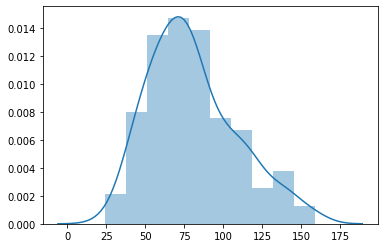

In [38]:
doc_len = [len(doc) for doc in Q_list]
import seaborn as sns

sns.distplot(doc_len);

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load("en_core_web_lg")
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(Q_list)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,adult,artery,attach,bacteria,benefit,biological,biological indicator,blood,cause,characterize,...,surgical team,team,temperature,term,term refer,tissue,transport,transport patient,tumor,type
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.453778,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.322445,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
from sklearn.neighbors import NearestNeighbors
# Knn state to save model and reduce computation time
class KnnState(object):
    def __init__(self):
        self._nn = "state"
        
    @property
    def test(self):
        return self._nn
    
    @test.setter
    def test(self, value):
        self._nn = value

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=20, algorithm='kd_tree')

KNN = KnnState()
KNN.nn = nn.fit(dtm)
KNN.nn

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                 radius=1.0)

In [52]:
search_term = ["""Steam Sterilzation"""]

new = tfidf.transform(search_term)

neighbors = KNN.nn.kneighbors(new.todense())
neighbors

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]),
 array([[ 29, 122, 114, 111,  83, 104, 141, 102,  60,  69,  32, 134,  16,
          43, 146, 170,  28,   3,  26,  18]], dtype=int64))

In [53]:
neighbors[1][0].tolist()
for i, x in enumerate(neighbors[1][0].tolist()):
    print(Q_list[x])

Q29. Which neurosurgical pathology would a myelogram diagnose?
Q122.When would the anesthesia provider request cricoid pressure?
Q114.What postoperative complication is associated with total hip arthroplasty?
Q111.Medication used to dilate the pupil is called?
Q83.The islets of Langerhans secrete?
Q104.What is the first step taken for an incorrect sponge count?
Q141.Hyperkalemia is a high concentration of?
Q102.The space between the vocal cords is called the?
Q60. Which laser is best used during a vitrectomy?
Q69. What is the next step for reattachment of a severed digit after debridement?
Q32. In what circumstances would cell saver transfusion be contraindicated?
Q134.What is the definition of otosclerosis?
16.How are rickettsiae transmitted?
Q43.The primary function of the gallbladder is to?
Q146.A partially dislocated joint is called?
Q170.What are the three factors for reducing ionizing radiation exposure?
Q28.Which microbes live without oxygen?
Q4.Permission for treatment given wi

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
from sklearn.feature_extraction.text import CountVectorizer

def vector_this(Q_list, search_term):
    
    def tokenize(document):
        doc = nlp(document)

        return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

    vect = CountVectorizer(stop_words='english', max_features=1000)

    # learn vocabulary
    vect.fit(Q_list)

    # Get sparse dtm
    dtm = vect.transform(Q_list)

    dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
    
    doc_len = [len(doc) for doc in Q_list]
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    nlp = spacy.load("en_core_web_lg")
    # Instantiate vectorizer object
    tfidf = TfidfVectorizer(stop_words='english', 
                            ngram_range=(1,2),
                            max_df=.97,
                            min_df=3,
                            tokenizer=tokenize)

    # Create a vocabulary and get word counts per document
    # Similiar to fit_predict
    dtm = tfidf.fit_transform(Q_list)

    # Print word counts

    # Get feature names to use as dataframe column headers
    dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

    # Fit on DTM
    nn = NearestNeighbors(n_neighbors=20, algorithm='kd_tree')

    KNN = KnnState()
    KNN.nn = nn.fit(dtm)
    new = tfidf.transform(search_term)

    neighbors = KNN.nn.kneighbors(new.todense())
    neighbors[1][0].tolist()
    output = []
    for i, x in enumerate(neighbors[1][0].tolist()):
        output.append(Q_list[x])

    return output
    
    

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
Doc =  ["""Steam"""]

vector_this(Q_list, Doc)

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Q29. Which neurosurgical pathology would a myelogram diagnose?',
 'Q122.When would the anesthesia provider request cricoid pressure?',
 'Q114.What postoperative complication is associated with total hip arthroplasty?',
 'Q111.Medication used to dilate the pupil is called?',
 'Q83.The islets of Langerhans secrete?',
 'Q104.What is the first step taken for an incorrect sponge count?',
 'Q141.Hyperkalemia is a high concentration of?',
 'Q102.The space between the vocal cords is called the?',
 'Q60. Which laser is best used during a vitrectomy?',
 'Q69. What is the next step for reattachment of a severed digit after debridement?',
 'Q32. In what circumstances would cell saver transfusion be contraindicated?',
 'Q134.What is the definition of otosclerosis?',
 '16.How are rickettsiae transmitted?',
 'Q43.The primary function of the gallbladder is to?',
 'Q146.A partially dislocated joint is called?',
 'Q170.What are the three factors for reducing ionizing radiation exposure?',
 'Q28.Which 

In [82]:
Doc =  ["""Steam sterilization"""]

vector_this(ans_list, Doc)

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['B. stearothermophilus is a microbe that is highly resistant to destruction by steam sterilization, but does not cause disease in humans. ',
 'The steam sterilization biological indicator must be incubated for 24 hours before the reading is recorded. ',
 'The biological indicator (BI) contains Bacillus stearothermophilus which is killed when exposed to steam sterilization conditions. Therefore, the BI is theonly test that guarantees sterility. ',
 'The four factors of steam sterilization are pressure, temperature, moisture and time. Pressure is used to increase the temperature of the steam to the level where it will kill microbes including spores. ',
 'An acute disease is one that has a rapid onset and is followed by a speedy recovery ',
 'Webbing of the digits is syndactyly',
 'An antagonist drug neutralizes or impedes the action of another drug; that is, reverses its effects.',
 'The islets of Langerhans secrete glucagon, insulin, somatostatin, and pancreatic polypeptide.',
 'Mitoch

In [90]:
Doc =  ["""Cancer Removal"""]

vector_this(ans_list, Doc)

d:\python projects\surgical_scraper\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Dilating drops are called mydriatics and are used to dilate the pupil for examination of the retina, refraction testing, or easier removal of the lens.(',
 'The removal of a tooth or teeth is an extraction procedure. The resection of the soft tissue and excision of the bone surrounding the tooth prior to the removal is called odontectomy.',
 'McBurney incision is primarily used for removal of the appendix. ',
 'McBurney incision is primarily used for removal of the appendix. ',
 'Hysterectomy is the medical term that means removal of the uterus. Hyster is the root word that means “uterus”; -ectomy is a suffix meaning “removal or excision of”. ',
 'An antagonist drug neutralizes or impedes the action of another drug; that is, reverses its effects.',
 'An acute disease is one that has a rapid onset and is followed by a speedy recovery ',
 'The islets of Langerhans secrete glucagon, insulin, somatostatin, and pancreatic polypeptide.',
 'Vaccination is artificially acquired active immuni